# Memory access

Useful resources: https://github.com/mitmath/18S096/blob/master/lectures/lecture4/memory.pdf and https://github.com/mitmath/18S096/blob/master/lectures/lecture4/memory-matrices.ipynb

## CPU specs

The built-in `versioninfo()` can be used to obtain the CPU model and the processor base frequency. If we want more information, we can use the package [CpuId.jl](https://github.com/m-j-w/CpuId.jl).

(Of course, we could also take a look at the [Intel specification of the i5-6600](https://ark.intel.com/content/www/de/de/ark/products/88188/intel-core-i5-6600-processor-6m-cache-up-to-3-90-ghz.html))

In [2]:
using CpuId
cpuinfo()

| Cpu Property       | Value                                                      |
|:------------------ |:---------------------------------------------------------- |
| Brand              | Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz                   |
| Vendor             | :Intel                                                     |
| Architecture       | :Kabylake                                                  |
| Model              | Family: 0x06, Model: 0x9e, Stepping: 0x0a, Type: 0x00      |
| Cores              | 6 physical cores, 12 logical cores (on executing CPU)      |
|                    | Hyperthreading detected                                    |
| Clock Frequencies  | 2600 / 4500 MHz (base/max), 100 MHz bus                    |
| Data Cache         | Level 1:3 : (32, 256, 12288) kbytes                        |
|                    | 64 byte cache line size                                    |
| Address Size       | 48 bits virtual, 39 bits physical                          |
| SIMD               | 256 bit = 32 byte max. SIMD vector size                    |
| Time Stamp Counter | TSC is accessible via `rdtsc`                              |
|                    | TSC runs at constant rate (invariant from clock frequency) |
| Perf. Monitoring   | Performance Monitoring Counters (PMC) revision 4           |
|                    | Available hardware counters per logical core:              |
|                    | 3 fixed-function counters of 48 bit width                  |
|                    | 4 general-purpose counters of 48 bit width                 |
| Hypervisor         | No                                                         |


We see that this machine is part of the Skylake family and supports **SIMD (Single Instructions Multiple Data)**. Concretely, registers are 256 bit/32 byte wide and 4 double precision floating point numbers (`Float64`) can be processed in each FMA unit. We can check explicitly that AVX2 instructions are available:

In [3]:
:AVX2 in cpufeatures() # alternatively, cpufeaturetable()

true

From the table above, we see that the L1, L2, and L3 cache sizes are 32 KB, 256 KB, and 12 MB:

In [12]:
cachesize()

(32768, 262144, 12582912)

## Cache topology

In [6]:
import Hwloc
Hwloc.topology_load()

D0: L0 P0 Machine  
    D1: L0 P0 Package  
        D2: L0 P-1 L3Cache  Cache{size=12582912,depth=3,linesize=64,associativity=0,type=Unified}
            D3: L0 P-1 L2Cache  Cache{size=262144,depth=2,linesize=64,associativity=4,type=Unified}
                D4: L0 P-1 L1Cache  Cache{size=32768,depth=1,linesize=64,associativity=0,type=Data}
                    D5: L0 P0 Core  
                        D6: L0 P0 PU  
                        D6: L1 P1 PU  
            D3: L1 P-1 L2Cache  Cache{size=262144,depth=2,linesize=64,associativity=4,type=Unified}
                D4: L1 P-1 L1Cache  Cache{size=32768,depth=1,linesize=64,associativity=0,type=Data}
                    D5: L1 P1 Core  
                        D6: L2 P2 PU  
                        D6: L3 P3 PU  
            D3: L2 P-1 L2Cache  Cache{size=262144,depth=2,linesize=64,associativity=4,type=Unified}
                D4: L2 P-1 L1Cache  Cache{size=32768,depth=1,linesize=64,associativity=0,type=Data}
                    D5: L2 P

## Microarchitecture: How many FMA/MUL/Add units?

We can consult the [Intel® 64 and IA-32 Architectures
Optimization Reference Manual
](https://software.intel.com/sites/default/files/managed/9e/bc/64-ia-32-architectures-optimization-manual.pdf) to get an impression of the Skylake microarchitecture:

<img src="memory_access_skylake_cpu.png" width=700px style="float: left">

We see that a core has **2 FMA/Add/MUL units** and **2 LD/STA (Load/Store address)**.

# `vecmul!`

In [13]:
function vecmul!(c,a,b)
    @assert length(a) == length(b) == length(c)
    n = length(c)
    @inbounds for i in 1:n
        c[i] = a[i] * b[i]
    end
    return c
end

vecmul(A, B) = vecmul!(Vector{promote_type(eltype(A), eltype(B))}(undef, length(A)), A, B)

vecmul (generic function with 1 method)

In [14]:
# correctness check:
using LinearAlgebra
a = rand(5)
b = rand(5)
vecmul(a,b) - a .* b

5-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0

#### Upper performance bound estimate: $P_{max}$

In [17]:
cycles_per_s = cpu_max_frequency() * 1e-3 # 4.5 GHz, assume turbo clock frequency
cycles_necessary = 3 # 3 LOAD, 1 STORE, 1 MUL 
fma_per_cycle = 2/cycles_necessary
flops_per_fma = 4
flops_per_cycle = flops_per_fma * fma_per_cycle
ncores = 1 # used cores

P_max = cycles_per_s * flops_per_cycle * ncores # Gflops/s

12.0

#### Benchmark

In [15]:
using BenchmarkTools
N = round.(Int, exp10.(range(1, log10(1_000_000), length=500)))  # 100 sizes from 10 to 3000
t = Float64[]
@time for n in N
    a = fill(1.2, n)
    b = fill(0.8, n)
    c = zeros(n)
    push!(t, @belapsed vecmul!($c,$a,$b))
    println("finished n = $n, time: ", t[end], " flops/t: ", n/t[end])
end

finished n = 10, time: 9.535535535535536e-9 flops/t: 1.0487087969766953e9
finished n = 10, time: 8.724724724724725e-9 flops/t: 1.1461679669573197e9
finished n = 10, time: 8.56156156156156e-9 flops/t: 1.1680112241318836e9
finished n = 11, time: 9.79079079079079e-9 flops/t: 1.1235047541151211e9
finished n = 11, time: 9.23123123123123e-9 flops/t: 1.1916070266753416e9
finished n = 11, time: 8.961961961961961e-9 flops/t: 1.227409806768681e9
finished n = 11, time: 9.182182182182181e-9 flops/t: 1.197972310040336e9
finished n = 12, time: 1.0281281281281281e-8 flops/t: 1.167169701100185e9
finished n = 12, time: 1.1012012012012011e-8 flops/t: 1.0897191164439597e9
finished n = 12, time: 9.543543543543545e-9 flops/t: 1.2573945877910635e9
finished n = 13, time: 9.76076076076076e-9 flops/t: 1.331863398625782e9
finished n = 13, time: 1.1037037037037037e-8 flops/t: 1.1778523489932885e9
finished n = 13, time: 9.907907907907908e-9 flops/t: 1.3120832491412406e9
finished n = 13, time: 9.438438438438439e-9

finished n = 129, time: 1.9317953861584754e-8 flops/t: 6.67772585669782e9
finished n = 133, time: 1.8442326980942826e-8 flops/t: 7.211671289498015e9
finished n = 136, time: 2.0149448345035104e-8 flops/t: 6.749564438249789e9
finished n = 139, time: 2.1844533600802407e-8 flops/t: 6.363147986592589e9
finished n = 142, time: 2.33925702811245e-8 flops/t: 6.070303446499849e9
finished n = 145, time: 2.2969909729187563e-8 flops/t: 6.312606436400157e9
finished n = 149, time: 2.1371113340020058e-8 flops/t: 6.972027972027973e9
finished n = 152, time: 2.2093373493975905e-8 flops/t: 6.879890933878664e9
finished n = 156, time: 2.2730923694779115e-8 flops/t: 6.862897526501767e9
finished n = 159, time: 2.721809045226131e-8 flops/t: 5.841702976146518e9
finished n = 163, time: 2.6419095477386936e-8 flops/t: 6.169779739034504e9
finished n = 167, time: 2.2580321285140563e-8 flops/t: 7.395820364606491e9
finished n = 171, time: 2.4874497991967873e-8 flops/t: 6.874510595358224e9
finished n = 175, time: 3.082

finished n = 1638, time: 2.504811827956989e-7 flops/t: 6.539413387136587e9
finished n = 1677, time: 2.87231884057971e-7 flops/t: 5.838488319289571e9
finished n = 1716, time: 2.821824561403509e-7 flops/t: 6.081171818656587e9
finished n = 1756, time: 2.969824561403509e-7 flops/t: 5.912807183364839e9
finished n = 1797, time: 3.42962962962963e-7 flops/t: 5.23963282937365e9
finished n = 1839, time: 3.239912663755459e-7 flops/t: 5.676078928215219e9
finished n = 1882, time: 3.138828451882845e-7 flops/t: 5.995867658428644e9
finished n = 1926, time: 3.2275757575757574e-7 flops/t: 5.967327011548212e9
finished n = 1971, time: 3.2330869565217395e-7 flops/t: 6.096340823818936e9
finished n = 2017, time: 3.4191705069124424e-7 flops/t: 5.899091595234244e9
finished n = 2064, time: 4.113417085427135e-7 flops/t: 5.01772603442589e9
finished n = 2112, time: 4.185778894472362e-7 flops/t: 5.045655905975005e9
finished n = 2161, time: 3.7063106796116506e-7 flops/t: 5.830595939751145e9
finished n = 2212, time: 

finished n = 22736, time: 8.510333333333334e-6 flops/t: 2.671575731463711e9
finished n = 23267, time: 8.467666666666667e-6 flops/t: 2.7477463291737194e9
finished n = 23810, time: 9.14e-6 flops/t: 2.6050328227571115e9
finished n = 24365, time: 8.996e-6 flops/t: 2.7084259670964875e9
finished n = 24934, time: 9.219e-6 flops/t: 2.704631738800304e9
finished n = 25516, time: 9.757e-6 flops/t: 2.615148098800861e9
finished n = 26112, time: 9.786e-6 flops/t: 2.668301655426119e9
finished n = 26721, time: 9.987e-6 flops/t: 2.675578251727246e9
finished n = 27345, time: 1.023e-5 flops/t: 2.6730205278592377e9
finished n = 27983, time: 1.0767e-5 flops/t: 2.598959784526795e9
finished n = 28636, time: 1.0747e-5 flops/t: 2.6645575509444494e9
finished n = 29304, time: 1.1015e-5 flops/t: 2.6603722197004085e9
finished n = 29988, time: 1.1302e-5 flops/t: 2.653335692797735e9
finished n = 30688, time: 1.1511e-5 flops/t: 2.6659716792633133e9
finished n = 31405, time: 1.1846e-5 flops/t: 2.651105858517643e9
fini

finished n = 397373, time: 0.00017887 flops/t: 2.2215743277240453e9
finished n = 406648, time: 0.000190405 flops/t: 2.1357002179564614e9
finished n = 416139, time: 0.000194116 flops/t: 2.1437645531537843e9
finished n = 425852, time: 0.000212217 flops/t: 2.0066818398149064e9
finished n = 435791, time: 0.000215289 flops/t: 2.0242139635559645e9
finished n = 445963, time: 0.00021298 flops/t: 2.0939196168654332e9
finished n = 456372, time: 0.00023404 flops/t: 1.9499743633566911e9
finished n = 467023, time: 0.000244473 flops/t: 1.9103254756148942e9
finished n = 477924, time: 0.000246784 flops/t: 1.9366085321576765e9
finished n = 489079, time: 0.000248108 flops/t: 1.9712343011914167e9
finished n = 500494, time: 0.000271166 flops/t: 1.8457107454474382e9
finished n = 512176, time: 0.000281965 flops/t: 1.8164523965740428e9
finished n = 524130, time: 0.000291096 flops/t: 1.8005400280319893e9
finished n = 536363, time: 0.000328571 flops/t: 1.6324112596668603e9
finished n = 548882, time: 0.00037424

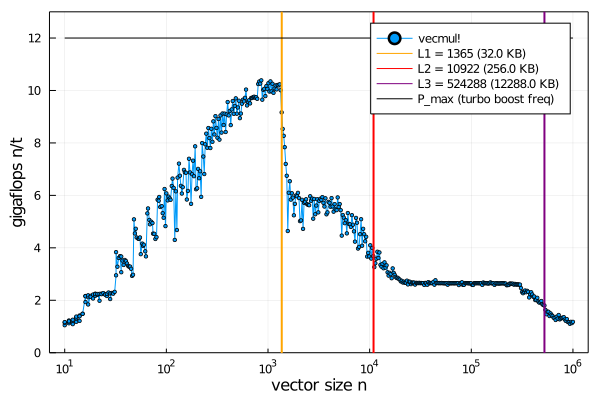

In [22]:
using Plots
plot(N, N ./ t * 1e-9, marker=:circle, label="vecmul!", frame=:box, ms=2, xscale=:log10)
ylabel!("gigaflops n/t")
xlabel!("vector size n")
ylims!(0,13)

L1,L2,L3 = cachesize()
mem = 3*sizeof(Float64) # three arrays, a, b, c
nL1 = L1/mem
nL2 = L2/mem
nL3 = L3/mem
vline!([nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) ($(L1/1024) KB)")
vline!([nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) ($(L2/1024) KB)")
vline!([nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) ($(L3/1024) KB)")

plot!([minimum(N),10^6],[P_max, P_max], color=:black, xscale=:log10, label="P_max (turbo boost freq)")

In [21]:
max_efficiency = round(maximum(N ./ t) * 1e-9 / P_max * 100, digits=1)
println(max_efficiency, "%")

86.6%


## `dot`

In [27]:
function mydot(a,b)
    @assert length(a) == length(b)
    s = zero(eltype(a))
    @inbounds for i in eachindex(a)
        s = s + a[i] * b[i]
    end
    return s
end

mydot (generic function with 1 method)

In [28]:
a = rand(5)
b = rand(5)
mydot(a,b) ≈ dot(a,b)

true

#### Upper performance bound estimate: $P_{max}$

In [29]:
cycles_per_s = cpu_max_frequency() * 1e-3 # 4.5 GHz, assume turbo clock frequency
cycles_necessary = 1 # 2 LOAD, 1 FMA
fma_per_cycle = 2/cycles_necessary
flops_per_fma = 4
flops_per_cycle = flops_per_fma * fma_per_cycle
ncores = 1 # used cores

P_max = cycles_per_s * flops_per_cycle * ncores # Gflops/s

36.0

#### Benchmark

In [27]:
using BenchmarkTools
Ndot = round.(Int, exp10.(range(1, log10(1_000_000), length=100)))
tdot = Float64[]
@time for n in Ndot
    a = fill(1.2, n)
    b = fill(0.8, n)
    push!(tdot, @belapsed dot($a,$b))
    println("finished n = $n, time: ", tdot[end], " flops/t: ", n/tdot[end])
end

finished n = 10, time: 1.4629258517034069e-8 flops/t: 6.835616438356165e8
finished n = 10, time: 1.4328657314629259e-8 flops/t: 6.97902097902098e8
finished n = 10, time: 1.4328657314629259e-8 flops/t: 6.97902097902098e8
finished n = 11, time: 1.533066132264529e-8 flops/t: 7.17516339869281e8
finished n = 11, time: 1.4813813813813815e-8 flops/t: 7.425501723089397e8
finished n = 11, time: 1.5730460921843688e-8 flops/t: 6.99280208930505e8
finished n = 11, time: 1.5530060120240483e-8 flops/t: 7.08303761533002e8
finished n = 12, time: 1.5930861723446894e-8 flops/t: 7.532549216931882e8
finished n = 12, time: 1.5930861723446894e-8 flops/t: 7.532549216931882e8
finished n = 12, time: 1.7034068136272544e-8 flops/t: 7.044705882352942e8
finished n = 13, time: 1.6331663326653305e-8 flops/t: 7.95999754586171e8
finished n = 13, time: 1.6733466933867736e-8 flops/t: 7.768862275449102e8
finished n = 13, time: 1.5630260521042085e-8 flops/t: 8.317199820501313e8
finished n = 13, time: 1.6331663326653305e-8 

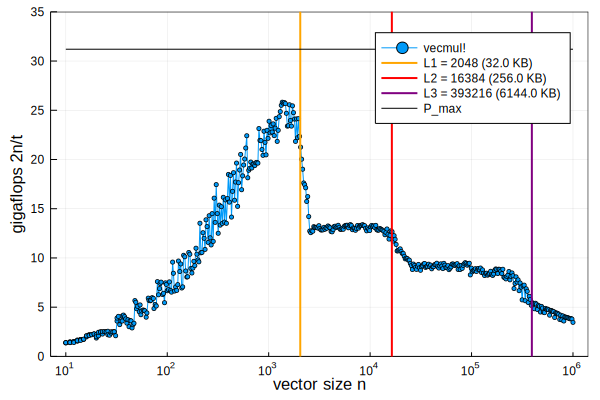

In [296]:
using Plots
plot(N, 2*N ./ tdot * 1e-9, marker=:circle, label="vecmul!", frame=:box, ms=2, xscale=:log10)
ylabel!("gigaflops 2n/t")
xlabel!("vector size n")
ylims!(0,35)

L1,L2,L3 = cachesize()
mem = 2*sizeof(Float64) # two arrays
nL1 = L1/mem
nL2 = L2/mem
nL3 = L3/mem
vline!([nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) ($(L1/1024) KB)")
vline!([nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) ($(L2/1024) KB)")
vline!([nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) ($(L3/1024) KB)")

plot!([minimum(N),10^6],[P_max, P_max], color=:black, xscale=:log10, label="P_max")

In [285]:
max_efficiency = round(maximum(2*N ./ tdot) * 1e-9 / P_max * 100, digits=1)
println(max_efficiency, "%")

82.8%
